In [1]:
"""
from sklearn.datasets import fetch_openml
from sklearn import datasets, svm, metrics
from pandas import DataFrame
import matplotlib as mpl
"""

from typing import List, Tuple
from dataclasses import dataclass
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib

import glob
import os
from pathlib import Path

# get nltk and corpus
import nltk
from nltk.corpus import stopwords

# get scapy and corpus
import spacy
import time
from functools import lru_cache

# Play with NLP
* https://spacy.io/
* https://www.nltk.org/

In [2]:
# This function is in the first block so you don't
# recreate it willy nilly, as it includes a cache.

nltk.download("stopwords")

# Remove domain words that don't help analysis.
# Should be factored out
domain_stop_words = set(
    """
    yes yup Affirmations get that's Journal
    Deliberate Disciplined Daily
    Know Essential Provide Context
    First Understand Appreciate
    """.lower().split()
)


@lru_cache(maxsize=4)
def get_nlp_model(model: str):
    start_time = time.time()
    print(f"Loading Model {model}")
    nlp = spacy.load(model)  # python -m spacy download en_core_web_lg
    spacy.prefer_gpu()  # This will be cool if/when it happens.
    duration = time.time() - start_time
    print(f"Took: {int(duration)}")
    return nlp


# Load corpus of my daily ramblings
@dataclass(frozen=True)
class Corpus:
    path: str
    all_content: str
    initial_words: List[str]
    words: List[str]

    def __hash__(self):
        return self.path.__hash__()


@lru_cache(maxsize=100)
def LoadCorpus(corpus_path: str) -> Corpus:

    # Hym consider memoizing this asweel..
    english_stop_words = set(stopwords.words("english"))
    all_stop_words = domain_stop_words | english_stop_words

    corpus_path_expanded = os.path.expanduser(corpus_path)
    corpus_files = glob.glob(corpus_path_expanded)

    """
    ######################################################
    # Performance side-bar.
    ######################################################

    A] Below code results in all strings Loaded into memory for temporary,  then merged into a second string.
    aka Memory = O(2*file_conent) and CPU O(2*file_content)

    B] An alternative is to do += on a string results in a new memory allocation and copy.
    aka Memory = O(file_content) , CPU O(files*file_content)

    However, this stuff needs to be measured, as it's also a funtion of GC. Not in the GC versions there is no change in CPU
    Eg.

    For A] if GC happens after every "join", then were down to O(file_content).
    For B] if no GC, then it's still O(2*file_content)
    """

    # Make single string from all the file contents.
    list_file_content = [Path(file_name).read_text() for file_name in corpus_files]
    all_file_content = " ".join(list_file_content)

    # Clean out some punctuation (although does that mess up stemming later??)
    initial_words = all_file_content.replace(",", " ").replace(".", " ").split()

    words = [word for word in initial_words if word.lower() not in all_stop_words]
    return Corpus(
        path=corpus_path,
        all_content=all_file_content,
        initial_words=initial_words,
        words=words,
    )


@lru_cache(maxsize=100)
def DocForCorpus(nlp, corpus: Corpus):
    print(
        f"initial words {len(corpus.initial_words)} remaining words {len(corpus.words)}"
    )
    print(f"Building corpus from {corpus.path} of len:{len(corpus.all_content)} ")
    start_time = time.time()
    # We use all_file_content not initial_words because we want to keep punctuation.
    doc_all = nlp(corpus.all_content)
    duration = time.time() - start_time

    # Remove domain specific stop words.
    doc = [token for token in doc_all if token.text.lower() not in domain_stop_words]
    print(f"Took: {int(duration)}")
    return doc

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/idvorkin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# make the plot wider
height_in_inches = 8
matplotlib.rc("figure", figsize=(2 * height_in_inches, height_in_inches))

### Load corpus from my journal

In [4]:
corpus_path = "~/gits/igor2/750words/2018*md"
# corpus_path = "/mnt/c/Users/idvor/OneDrive/backup/Diary/*txt"

corpus = LoadCorpus(corpus_path)
print(f"initial words {len(corpus.initial_words)} remaining words {len(corpus.words)}")

initial words 51189 remaining words 25003


In [5]:
# Could use nltk frequency distribution, but better off building our own.
# fd = nltk.FreqDist(words)
# fd.plot(50, percents=True)

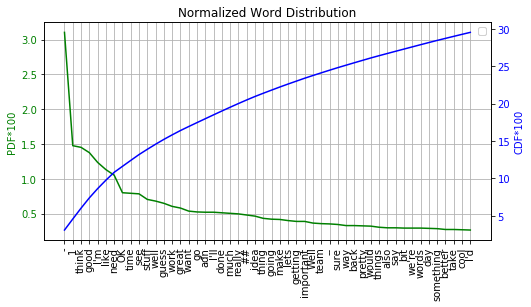

In [6]:
# Same as NLTK FreqDist, except normalized, includes cumsum, and colors
def GraphWordDistribution(words, title="", skip=0, length=50, includeCDF=True) -> None:
    def GetPDFCDF(words):
        def ToPercent(x: float) -> float:
            return x * 100

        # NOTE: No point creating a full data frame when only using a single column.
        pdf = pd.Series(words).value_counts(normalize=True).apply(ToPercent)
        cdf = pdf.cumsum()
        return (pdf, cdf)

    def PlotOnAxis(series, ax, label: str, color: str):
        # RANT: Why is MPL so confusing? The OO interface vs the stateful interface, GRAH!!
        # The random non-obvious calls.
        # GRAH!!!

        ax.legend(label.split())
        ax.plot(series, color=color)

        # RANT: Why no YAxis.set_labal_params()? E.g.
        #                 ax.yaxis.set_label_params(label, color=color)
        ax.set_ylabel(label, color=color)
        ax.yaxis.set_tick_params(labelcolor=color)

        # technically all the X axis paramaters are duplicated since we "twinned the X paramater"
        ax.xticks = range(len(series))

        # RANT: rot can be set on plt.plot(), but not on axes.plot()
        ax.xaxis.set_tick_params(rotation=90)

    # NOTE: can make graph prettier with styles E.g.
    # with plt.style.context("ggplot"):
    fig, ax = plt.subplots(1)

    ax.set_title(title)
    ax.grid(True)

    # make pdf first axes, and cdf second axes.
    ax_pdf, ax_cdf = (ax, ax.twinx())
    color_pdf, color_cdf = ("green", "blue")
    pdf, cdf = GetPDFCDF(words)

    PlotOnAxis(pdf[skip : skip + length], ax_pdf, label="PDF*100", color=color_pdf)
    PlotOnAxis(cdf[skip : skip + length], ax_cdf, label="CDF*100", color=color_cdf)


GraphWordDistribution(corpus.words, title="Normalized Word Distribution")

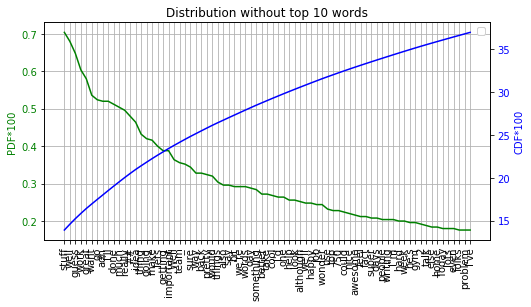

In [7]:
skip = 10
GraphWordDistribution(
    corpus.words, skip=skip, length=75, title=f"Distribution without top {skip} words"
)

In [8]:
# wordcloud is non-deterministic, which is bizarre.
# from wordcloud import WordCloud
# wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords=None).generate("".join(words))
# plt.imshow(wordcloud,  interpolation='bilinear')

# Play with POS tagging and lemmatisation

In [ ]:
nlp = get_nlp_model("en_core_web_lg")
nlp.max_length = 100 * 1000 * 1000


def GetInterestingWords(pos: str, doc, corpus: Corpus):
    interesting_pos = pos
    interesting_pos_set = set(interesting_pos.split())
    interesting = [token for token in doc if token.pos_ in interesting_pos_set]
    interesting_words = [token.lemma_ for token in interesting]
    return interesting_words


def GraphPoSForDoc(pos: str, doc, corpus):
    GraphWordDistribution(
        GetInterestingWords(pos, doc, corpus=corpus),
        title=f"Distribution of {pos} on {corpus.path}",
        skip=0,
        length=20,
    )


def GraphScratchForCorpus(corpus_path: str, pos: str = "NOUN VERB ADJ ADV"):
    corpus = LoadCorpus(corpus_path)
    doc = DocForCorpus(nlp, corpus)
    GraphPoSForDoc(pos, doc, corpus)


def GetInterestingForCorpusPath(corpus_path: str, pos: str = "NOUN VERB ADJ ADV"):
    corpus = LoadCorpus(corpus_path)
    doc = DocForCorpus(nlp, corpus)
    return GetInterestingWords(pos, doc, corpus)

['~/gits/igor2/750words_archive/750 Words-export-2018-03-01.txt', '~/gits/igor2/750words_archive/750 Words-export-2018-04-01.txt', '~/gits/igor2/750words_archive/750 Words-export-2018-05-01.txt', '~/gits/igor2/750words_archive/750 Words-export-2018-06-01.txt', '~/gits/igor2/750words_archive/750 Words-export-2018-07-01.txt', '~/gits/igor2/750words/2018-09-*md', '~/gits/igor2/750words/2018-10-*md', '~/gits/igor2/750words/2018-11-*md', '~/gits/igor2/750words/2018-12-*md']


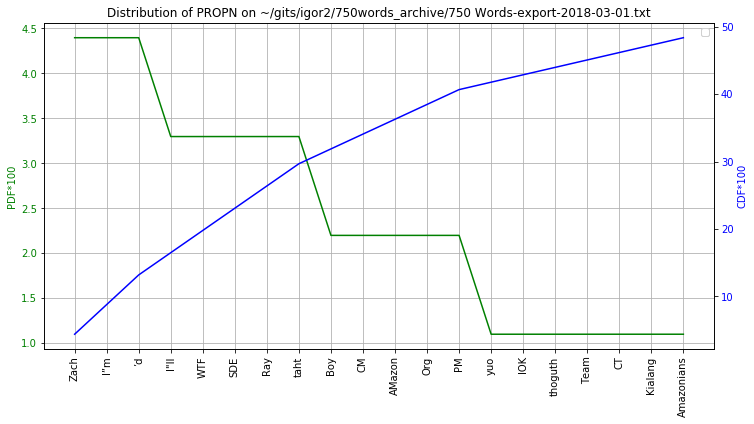

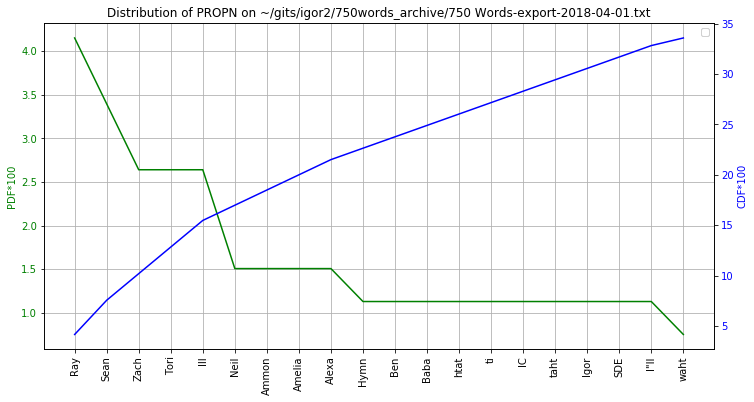

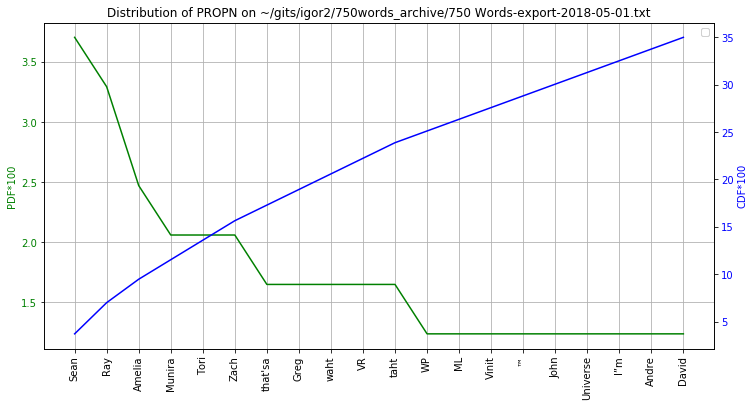

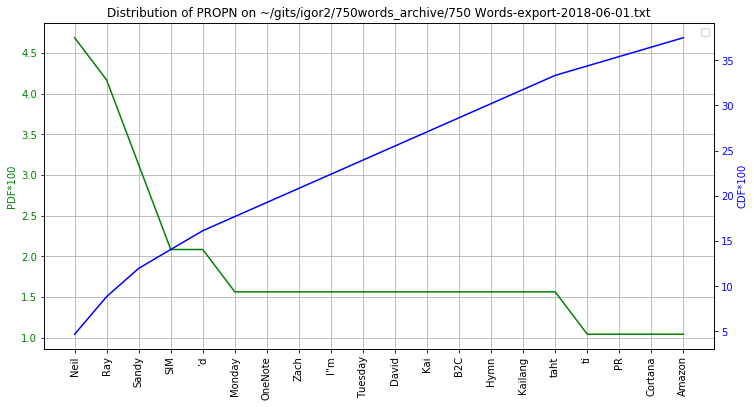

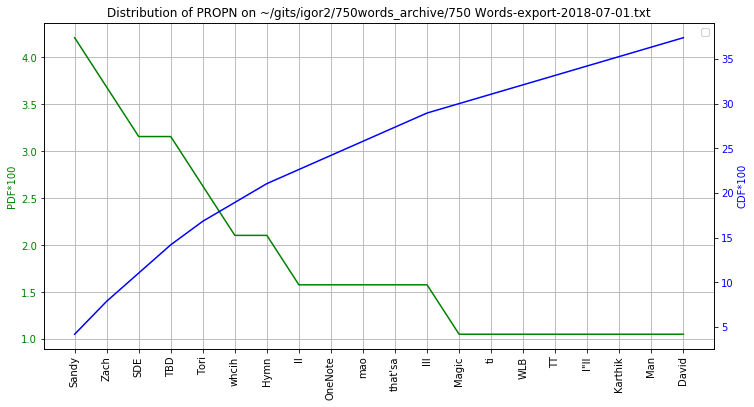

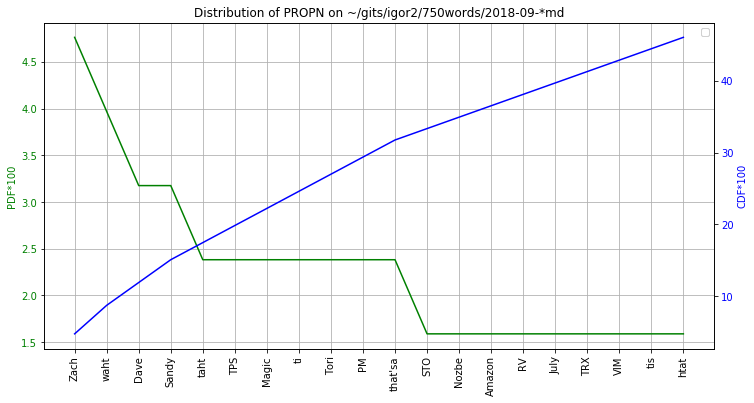

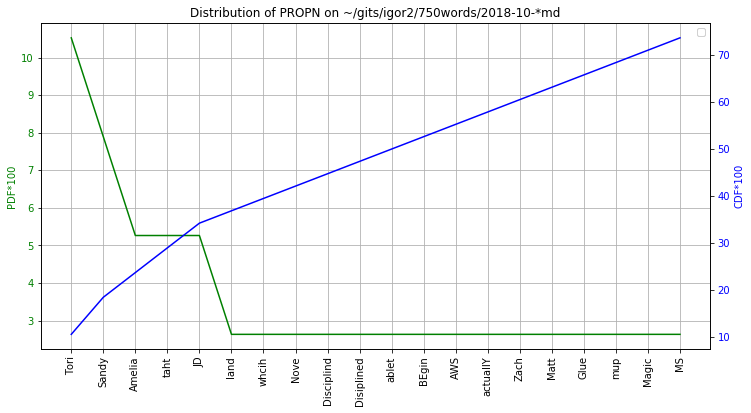

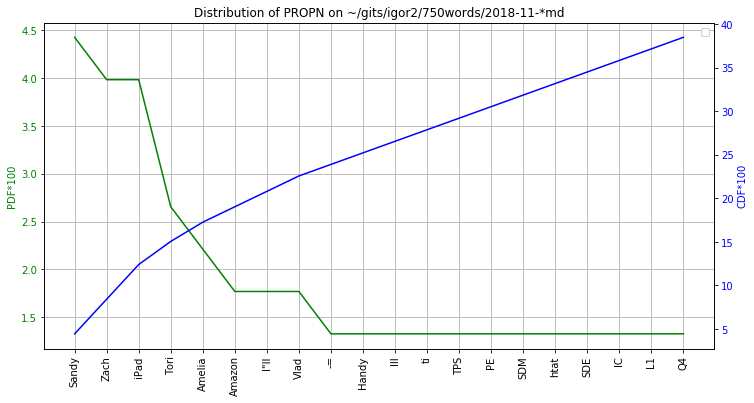

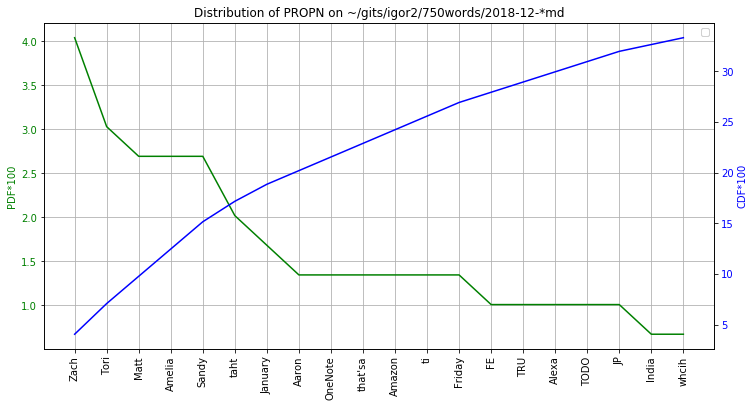

In [235]:
corpus_paths_months_2019 = [
    "~/gits/igor2/750words/2018-09-*md",
    "~/gits/igor2/750words/2018-10-*md",
    "~/gits/igor2/750words/2018-11-*md",
    "~/gits/igor2/750words/2018-12-*md",
    "~/gits/igor2/750words/2019-01-*md",
    "~/gits/igor2/750words/2019-02-*md",
    "~/gits/igor2/750words/2019-03-*md",
    "~/gits/igor2/750words/2019-04-*md",
    "~/gits/igor2/750words/2019-05*md",
    "~/gits/igor2/750words/2019-06-*md",
] 

#Words-export-2018-03-01.txt
# 750 Words-export-2019-06-01.txt
# I didn't really write in 2018 Jan/Feb
corpus_paths_months_2018 =  [f"~/gits/igor2/750words_archive/750 Words-export-2018-0{i}-01.txt" for i in range(3,8)] +  [
    "~/gits/igor2/750words/2018-09-*md",
    "~/gits/igor2/750words/2018-10-*md",
    "~/gits/igor2/750words/2018-11-*md",
    "~/gits/igor2/750words/2018-12-*md",
    ]
print (corpus_paths_months_2018)

corpus_paths_years = [
    "~/gits/igor2/750words_archive/*2012*txt",
    "~/gits/igor2/750words_archive/*2013*txt",
    "~/gits/igor2/750words_archive/*2014*txt",
    "~/gits/igor2/750words_archive/*2015*txt",
    "~/gits/igor2/750words_archive/*2016*txt",
    "~/gits/igor2/750words_archive/*2017*txt",
    "~/gits/igor2/750words_archive/*2018*txt",
    "~/gits/igor2/750words/2018*md",
    "~/gits/igor2/750words/2019-*md",
]

corpus_paths = corpus_paths_years
corpus_paths = corpus_paths_months_2018
for c in corpus_paths:
    GraphScratchForCorpus(c, pos="PROPN")

# Debugging when stuff goes goofy.

In [213]:
_ = """
max_to_analyze = 15
interesting = [token for token in doc if token.tag_ == "NNS"]
for token in interesting[:max_to_analyze]:
    # print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_, token.shape_, token.is_alpha, token.is_stop)
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_)

# Parts of speech: https://spacy.io/usage/linguistic-features
GraphWordDistribution([token.pos_ for token in doc], title=f"POS Distribution on {corpus_path}")
# interesting = [ token for token in doc if token.pos_ != "PUNCT" and token.pos_ != "SYM" and len(token.text) > 3]
"""

In [214]:
# Visualizing thinking over time.
# A] Sentiment over time. Graph valence as line graph time series (TBD: Use cloud service to analyze each file)
# B] Graph a bar chart of Proper noun, have it update per corpus file.
#        Leave the x axis where they are.

In [215]:
# build a data frame of word frequency "Proper Noun"x"Corpus"
# Should sort by Time based impactful proper noun.
# Row subtitle is the "Time based Maximum Proper Noun"
# Graph update every second.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1fd5f3b70>,
      dtype=object)

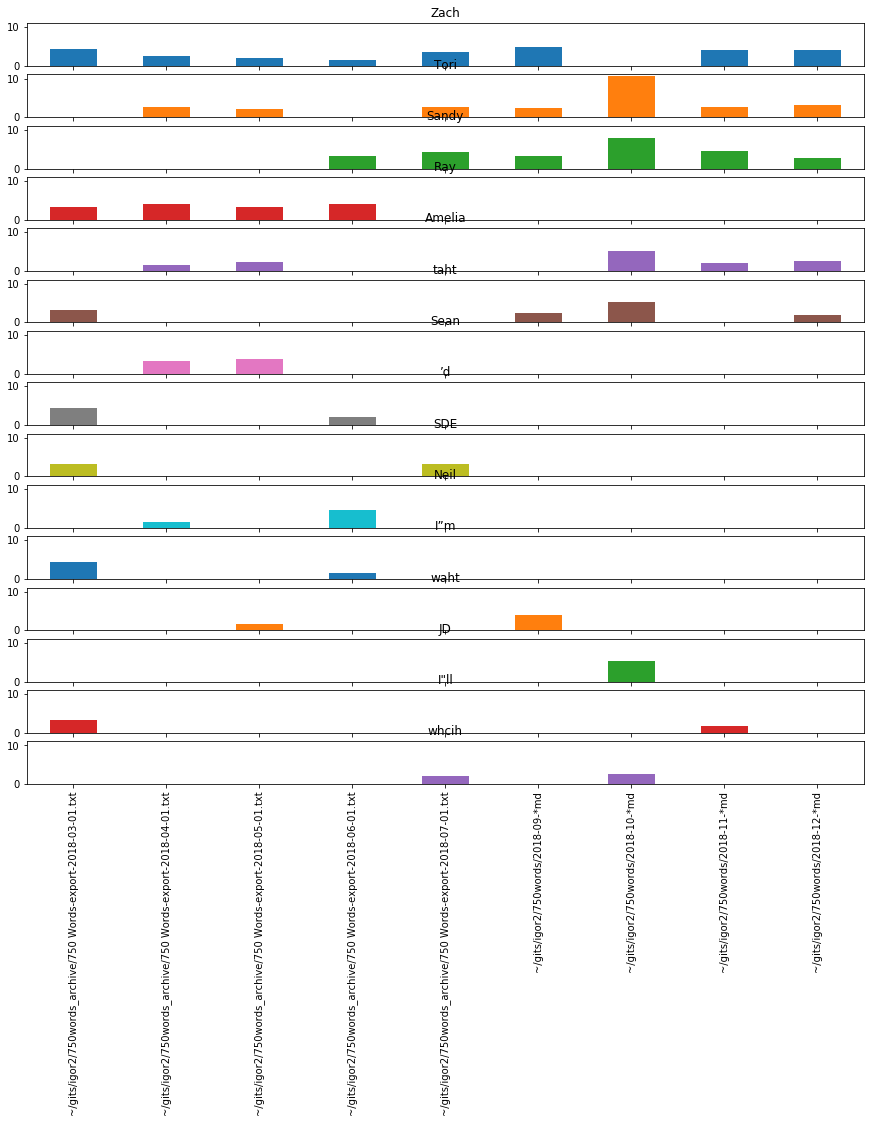

In [236]:
# yup going to need some refactoring
nlp = get_nlp_model("en_core_web_lg")

# corpus = LoadCorpus(corpus_path)
# DocForCorpus(nlp, LoadCorpus(p))


def GetPDFCDF(words, path):
    def ToPercent(x: float) -> float:
        return x * 100

    # NOTE: No point creating a full data frame when only using a single column.
    pdf = pd.Series(words, name=path).value_counts(normalize=True).apply(ToPercent)
    cdf = pdf.cumsum()
    return (pdf, cdf)


corpus = [
    GetPDFCDF(GetInterestingForCorpusPath(p, "PROPN"), p)[0][:10] for p in corpus_paths
]

# [Series[idx=word, value=PropN_Frequency]]
#wordByTimespan = pd.DataFrame().join(corpus, how="outer", sort=False)
wordByTimespan = pd.DataFrame()
for r in corpus: 
    wordByTimespan = wordByTimespan.join(r, how="outer")

# Sort by word frequency
wordByTimespan["word_frequency"] = wordByTimespan.sum(skipna=True, axis="columns")
wordByTimespan = wordByTimespan.sort_values("word_frequency", ascending=False)

# Remove total column
wordByTimespan = wordByTimespan.iloc[:, :-1]

height_in_inches = 6
matplotlib.rc("figure", figsize=(2 * height_in_inches, height_in_inches))

# combined bar graph
# wordByTimespan.iloc[:10,:].plot(kind="bar",subplots=False, legend=True, animated=True, figsize=(16,8))

# subplot per month
# wordByTimespan.plot(kind="bar",subplots=True, legend=False)

# subplot per month - top 10
# XXX: Interesting - you need to syncronize all subplots to be same height as they all have the same axix
wordByTimespan.iloc[:15, :].T.plot( kind="bar", subplots=True, legend=False, figsize=(15, 14), sharey=True )